# Section 2: Thuật toán Ada

## 2.1. Khái quát về thuật toán Ada (còn gọi là AdaDelta)

Theo chương 12.9 – Adadelta trong sách D2L, AdaDelta được đề xuất nhằm khắc phục nhược điểm lớn của Adagrad, vốn cộng dồn gradient theo thời gian khiến mẫu số trong công thức cập nhật ngày càng tăng và làm learning rate giảm nhanh đến mức gần bằng 0, dẫn đến mô hình ngừng học. Để giải quyết vấn đề này, AdaDelta thay thế tổng cộng dồn bằng cơ chế trung bình trượt mũ (EMA) giúp kiểm soát độ lớn của gradient theo thời gian, đồng thời chuẩn hóa bước cập nhật dựa trên hai giá trị EMA để loại bỏ nhu cầu lựa chọn learning rate thủ công.

## 2.2. Công thức xử lý của thuật toán Ada
Bước 1 – Ước lượng trung bình bình phương gradient

Sách D2L định nghĩa:

$$E[g_t^2] = \rho E[g_{t-1}^2] + (1 - \rho)g_t^2$$

Trong đó:
- $g_t$: gradient tại thời điểm $t$
- $\rho$: hệ số suy giảm
- $E[g_t^2]$: EMA của bình phương gradient

**Ý nghĩa:** Thay vì *nhớ toàn bộ lịch sử gradient* như Adagrad, AdaDelta chỉ nhớ xu hướng gần đây.

Bước 2 – Tính bước cập nhật Δx

AdaDelta định nghĩa một dạng learning rate thích nghi bằng cách cân bằng giữa "độ lớn của bước cập nhật trước" và "độ lớn gradient hiện tại":

$$\Delta x_t = -\frac{\sqrt{E[\Delta x_t^2]_{t-1}} + \epsilon}{\sqrt{E[g_t^2]} + \epsilon} g_t$$

Trong đó:
- $E[\Delta x_t^2]_{t-1}$: EMA của bình phương bước cập nhật trước
- $\epsilon$: hằng số nhỏ ($10^{-6}$) để tránh chia cho 0

**Điểm quan trọng:** AdaDelta **không cần learning rate η** vì tỉ lệ trên tự điều chỉnh bước nhảy.

Bước 3 – Cập nhật EMA của bước nhảy

$$E[\Delta x_t^2] = \rho E[\Delta x_{t-1}^2] + (1-\rho)(\Delta x_t)^2$$

Bước 4 – Cập nhật tham số

$$x_{t+1} = x_t + \Delta x_t$$

## 2.3. Ý nghĩa các đại lượng trong AdaDelta

| Ký hiệu | Ý nghĩa |
|---------|---------|
| $\rho$ | Hệ số suy giảm, điều khiển mức "ghi nhớ" gradient cũ. |
| $\epsilon$ | Tránh chia cho 0, đồng thời ổn định mẫu số. |
| $E[g_t^2]$ | EMA của bình phương gradient, xấp xỉ phương sai gradient. |
| $E[\Delta x_t^2]$ | EMA của bình phương bước cập nhật, giúp cân bằng bước nhảy. |
| $g_t$ | Gradient tại thời điểm t. |
| $\Delta x_t$ | Bước điều chỉnh trọng số. |
| $x_t$ | Trọng số mô hình tại thời điểm t. |

## 2.4. Vì sao AdaDelta khắc phục hạn chế của Adagrad? (Dựa theo D2L mục 12.7 và 12.9)

Trong **chương 12.7** Adagrad, D2L chỉ ra hạn chế:

- Tổng bình phương gradient:

$$G_t = \sum_{\tau=1}^{t} g_\tau^2$$

- Khi $t$ tăng → $G_t$ tăng không giới hạn → learning rate

$$\frac{1}{\sqrt{G_t}}$$

→ giảm dần về 0.

**Hệ quả:** mô hình ngừng học.

**AdaDelta xử lý bằng 3 cơ chế chính:**

**(1) Dùng EMA thay vì tổng cộng dồn**

$$E[g_t^2]$$

luôn bị "làm quên dần", không bao giờ tăng tới vô cực → mẫu số luôn ổn định.

**(2) Thay learning rate bằng tỉ lệ hai EMA**

$$\frac{\sqrt{E[\Delta x_t^2]_{t-1}}}{\sqrt{E[g_t^2]}}$$

→ Nếu gradient đang nhỏ → bước nhảy tăng lên  
→ Nếu gradient đang lớn → bước nhảy giảm xuống  
→ **Không bao giờ bị tắc nghẽn như Adagrad.**

**(3) Không cần learning rate η**

D2L cũng nhấn mạnh rằng AdaDelta hoàn toàn loại bỏ η, giảm đáng kể công sức tinh chỉnh siêu tham số.

## 2.5. Triển khai và Thực nghiệm

### 2.5.1. Import thư viện cần thiết

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Thiết lập style cho biểu đồ
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

### 2.5.2. Định nghĩa hàm mục tiêu - Rosenbrock Function

Sử dụng hàm Rosenbrock, một benchmark function phổ biến:

$$f(x, y) = (1-x)^2 + 100(y-x^2)^2$$

- **Điểm tối ưu:** $(x^*, y^*) = (1, 1)$
- **Giá trị tối ưu:** $f(x^*, y^*) = 0$

In [2]:
def rosenbrock(x, y):
    """Hàm Rosenbrock"""
    return (1 - x)**2 + 100 * (y - x**2)**2

def rosenbrock_gradient(x, y):
    """Gradient của hàm Rosenbrock"""
    dx = -2 * (1 - x) - 400 * x * (y - x**2)
    dy = 200 * (y - x**2)
    return np.array([dx, dy])

### 2.5.3. Triển khai thuật toán AdaDelta

In [3]:
def adadelta(gradient_func, initial_params, rho=0.95, epsilon=1e-6, num_iterations=1000):
    """
    Thuật toán AdaDelta optimization
    
    Parameters:
    -----------
    gradient_func : function
        Hàm tính gradient
    initial_params : array
        Tham số khởi tạo [x0, y0]
    rho : float
        Hệ số decay cho EMA (default: 0.95)
    epsilon : float
        Hằng số nhỏ để tránh chia cho 0 (default: 1e-6)
    num_iterations : int
        Số lần lặp
    
    Returns:
    --------
    params_history : array
        Lịch sử các tham số qua mỗi iteration
    loss_history : array
        Lịch sử giá trị loss
    """
    # Khởi tạo
    params = np.array(initial_params, dtype=float)
    E_g2 = np.zeros_like(params)  # EMA của bình phương gradient
    E_delta2 = np.zeros_like(params)  # EMA của bình phương bước cập nhật
    
    params_history = [params.copy()]
    loss_history = [rosenbrock(params[0], params[1])]
    
    for i in range(num_iterations):
        # Bước 1: Tính gradient tại điểm hiện tại
        g = gradient_func(params[0], params[1])
        
        # Bước 2: Cập nhật EMA của bình phương gradient
        E_g2 = rho * E_g2 + (1 - rho) * g**2
        
        # Bước 3: Tính RMS của gradient và delta
        rms_g = np.sqrt(E_g2 + epsilon)
        rms_delta = np.sqrt(E_delta2 + epsilon)
        
        # Bước 4: Tính bước cập nhật
        delta = -(rms_delta / rms_g) * g
        
        # Bước 5: Cập nhật EMA của bình phương delta
        E_delta2 = rho * E_delta2 + (1 - rho) * delta**2
        
        # Bước 6: Cập nhật tham số
        params = params + delta
        
        # Lưu lịch sử
        params_history.append(params.copy())
        loss_history.append(rosenbrock(params[0], params[1]))
        
        # Kiểm tra hội tụ
        if i > 0 and abs(loss_history[-1] - loss_history[-2]) < 1e-9:
            break
    
    return np.array(params_history), np.array(loss_history)

### 2.5.4. Triển khai Adagrad (để so sánh)

In [4]:
def adagrad(gradient_func, initial_params, learning_rate=0.1, epsilon=1e-6, num_iterations=1000):
    """Thuật toán Adagrad optimization (để so sánh)"""
    params = np.array(initial_params, dtype=float)
    G = np.zeros_like(params)  # Tổng tích lũy bình phương gradient
    
    params_history = [params.copy()]
    loss_history = [rosenbrock(params[0], params[1])]
    
    for i in range(num_iterations):
        g = gradient_func(params[0], params[1])
        
        # Cộng dồn bình phương gradient
        G = G + g**2
        
        # Cập nhật tham số
        params = params - learning_rate * g / (np.sqrt(G) + epsilon)
        
        params_history.append(params.copy())
        loss_history.append(rosenbrock(params[0], params[1]))
    
    return np.array(params_history), np.array(loss_history)

### 2.5.5. Chạy thử nghiệm với các giá trị ρ khác nhau

In [5]:
# Điểm khởi tạo
initial_point = [-1.0, 2.0]
num_iters = 500

# Chạy AdaDelta với các giá trị rho khác nhau
print("=== Chạy AdaDelta với các giá trị ρ khác nhau ===\n")

rho_values = [0.9, 0.95, 0.99]
adadelta_results = {}

for rho in rho_values:
    print(f"ρ = {rho}")
    params_hist, loss_hist = adadelta(
        rosenbrock_gradient, 
        initial_point, 
        rho=rho, 
        num_iterations=num_iters
    )
    adadelta_results[rho] = {
        'params': params_hist,
        'loss': loss_hist
    }
    final_params = params_hist[-1]
    final_loss = loss_hist[-1]
    print(f"  Final params: x={final_params[0]:.6f}, y={final_params[1]:.6f}")
    print(f"  Final loss: {final_loss:.6e}")
    print(f"  Total iterations: {len(params_hist)-1}\n")

# Chạy Adagrad để so sánh
print("=== Chạy Adagrad để so sánh ===\n")
params_adagrad, loss_adagrad = adagrad(
    rosenbrock_gradient, 
    initial_point, 
    learning_rate=0.1,
    num_iterations=num_iters
)
final_params_adagrad = params_adagrad[-1]
final_loss_adagrad = loss_adagrad[-1]
print(f"Final params: x={final_params_adagrad[0]:.6f}, y={final_params_adagrad[1]:.6f}")
print(f"Final loss: {final_loss_adagrad:.6e}")
print(f"Total iterations: {len(params_adagrad)-1}")

=== Chạy AdaDelta với các giá trị ρ khác nhau ===

ρ = 0.9
  Final params: x=-0.919542, y=0.855064
  Final loss: 3.693679e+00
  Total iterations: 500

ρ = 0.95
  Final params: x=-1.048479, y=1.108844
  Final loss: 4.205360e+00
  Total iterations: 500

ρ = 0.99
  Final params: x=-1.290267, y=1.671513
  Final loss: 5.249844e+00
  Total iterations: 500

=== Chạy Adagrad để so sánh ===

Final params: x=-1.213772, y=1.479960
Final loss: 4.905299e+00
Total iterations: 500


### 2.5.6. Visualization - Contour Plot

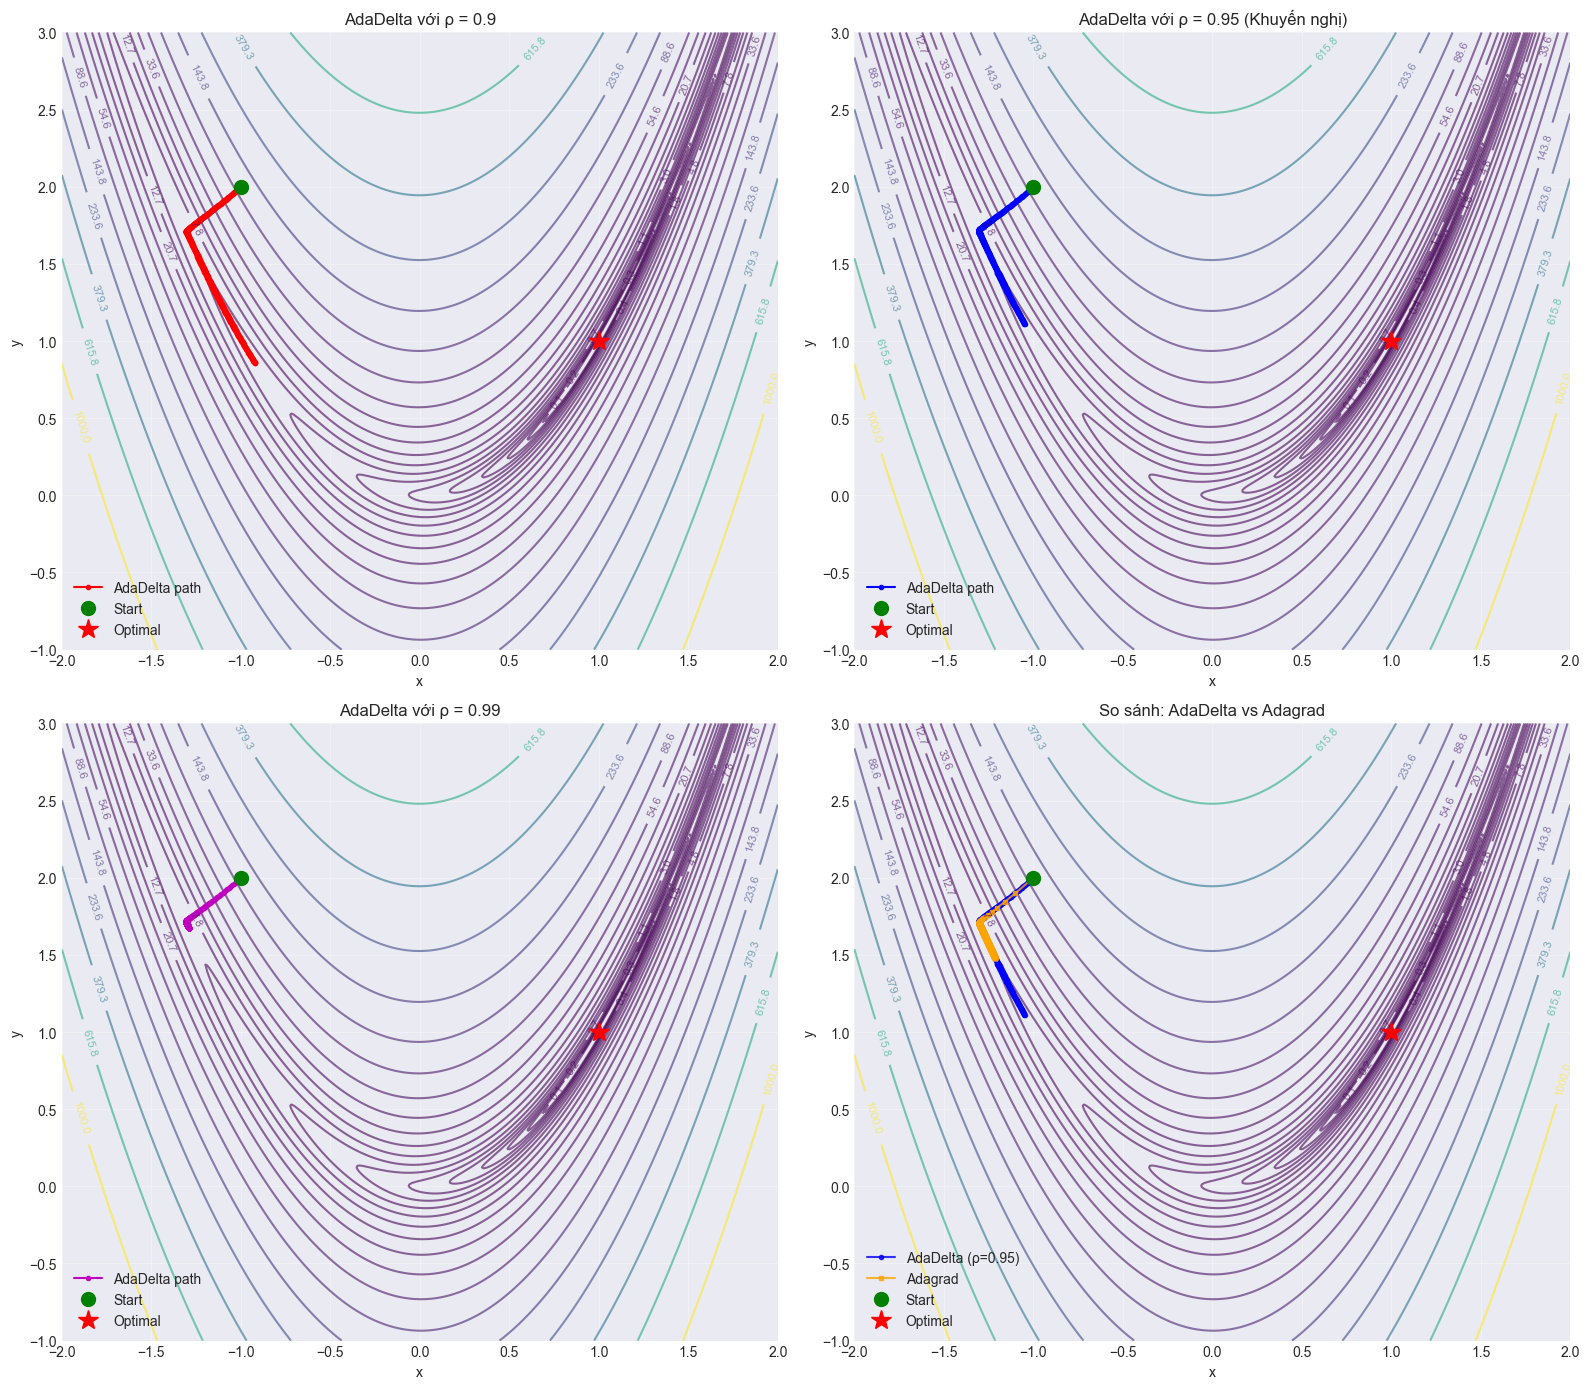

In [6]:
# Tạo lưới để vẽ contour
x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x, y)
Z = rosenbrock(X, Y)

# Vẽ contour plot
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: AdaDelta với ρ=0.9
ax = axes[0, 0]
contour = ax.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='viridis', alpha=0.6)
ax.clabel(contour, inline=True, fontsize=8)
params = adadelta_results[0.9]['params']
ax.plot(params[:, 0], params[:, 1], 'r-o', markersize=3, linewidth=1.5, label='AdaDelta path')
ax.plot(initial_point[0], initial_point[1], 'go', markersize=10, label='Start', zorder=5)
ax.plot(1, 1, 'r*', markersize=15, label='Optimal', zorder=5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('AdaDelta với ρ = 0.9')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: AdaDelta với ρ=0.95
ax = axes[0, 1]
contour = ax.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='viridis', alpha=0.6)
ax.clabel(contour, inline=True, fontsize=8)
params = adadelta_results[0.95]['params']
ax.plot(params[:, 0], params[:, 1], 'b-o', markersize=3, linewidth=1.5, label='AdaDelta path')
ax.plot(initial_point[0], initial_point[1], 'go', markersize=10, label='Start', zorder=5)
ax.plot(1, 1, 'r*', markersize=15, label='Optimal', zorder=5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('AdaDelta với ρ = 0.95 (Khuyến nghị)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: AdaDelta với ρ=0.99
ax = axes[1, 0]
contour = ax.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='viridis', alpha=0.6)
ax.clabel(contour, inline=True, fontsize=8)
params = adadelta_results[0.99]['params']
ax.plot(params[:, 0], params[:, 1], 'm-o', markersize=3, linewidth=1.5, label='AdaDelta path')
ax.plot(initial_point[0], initial_point[1], 'go', markersize=10, label='Start', zorder=5)
ax.plot(1, 1, 'r*', markersize=15, label='Optimal', zorder=5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('AdaDelta với ρ = 0.99')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: So sánh AdaDelta vs Adagrad
ax = axes[1, 1]
contour = ax.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='viridis', alpha=0.6)
ax.clabel(contour, inline=True, fontsize=8)
params_ada095 = adadelta_results[0.95]['params']
ax.plot(params_ada095[:, 0], params_ada095[:, 1], 'b-o', markersize=3, linewidth=1.5, 
        label='AdaDelta (ρ=0.95)', alpha=0.8)
ax.plot(params_adagrad[:, 0], params_adagrad[:, 1], 'orange', marker='s', markersize=3, 
        linewidth=1.5, label='Adagrad', alpha=0.8)
ax.plot(initial_point[0], initial_point[1], 'go', markersize=10, label='Start', zorder=5)
ax.plot(1, 1, 'r*', markersize=15, label='Optimal', zorder=5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('So sánh: AdaDelta vs Adagrad')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.5.7. So sánh tốc độ hội tụ

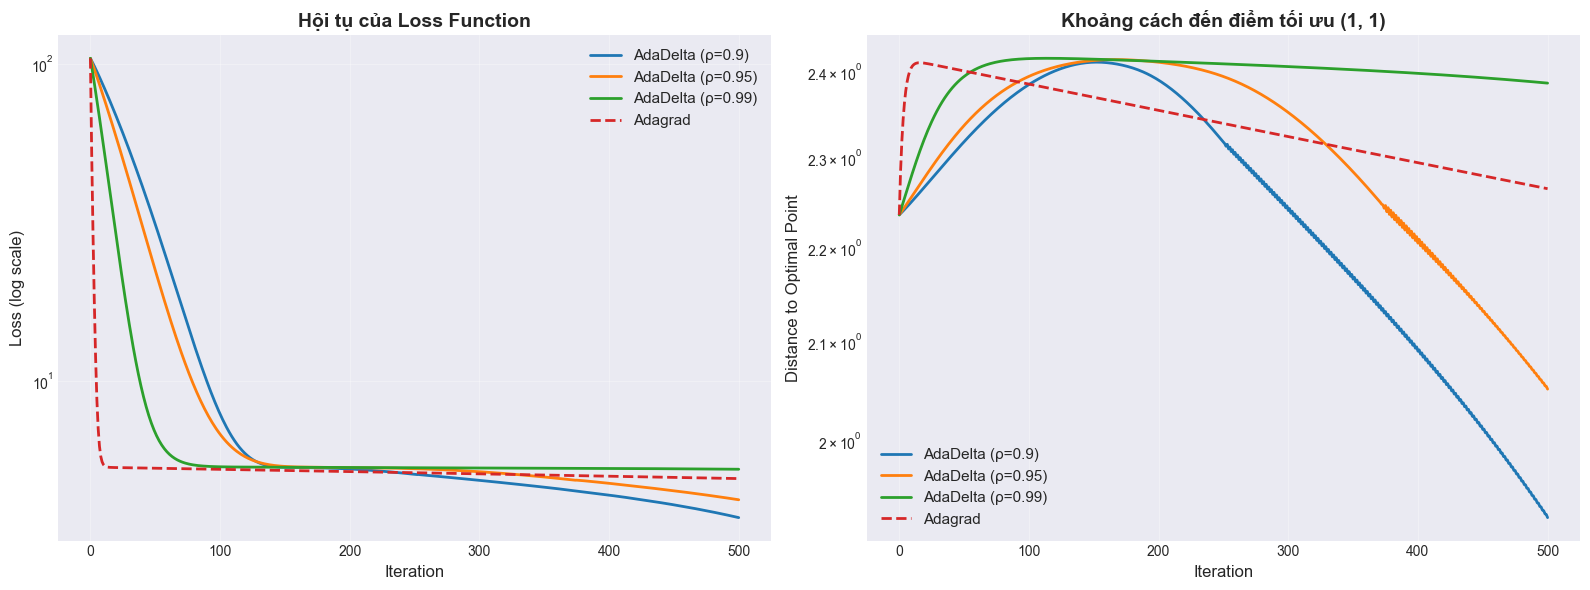


📊 Phân tích kết quả:
Thuật toán           Final Loss      Iterations  
AdaDelta (ρ=0.9 )       3.69e+00         500
AdaDelta (ρ=0.95)       4.21e+00         500
AdaDelta (ρ=0.99)       5.25e+00         500
Adagrad                    4.91e+00         500


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Loss theo iterations (log scale)
ax = axes[0]
for rho in rho_values:
    loss = adadelta_results[rho]['loss']
    ax.plot(loss, label=f'AdaDelta (ρ={rho})', linewidth=2)
ax.plot(loss_adagrad, label='Adagrad', linewidth=2, linestyle='--')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Loss (log scale)', fontsize=12)
ax.set_yscale('log')
ax.set_title('Hội tụ của Loss Function', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 2: Khoảng cách đến điểm tối ưu
ax = axes[1]
for rho in rho_values:
    params = adadelta_results[rho]['params']
    distance = np.sqrt((params[:, 0] - 1)**2 + (params[:, 1] - 1)**2)
    ax.plot(distance, label=f'AdaDelta (ρ={rho})', linewidth=2)
distance_adagrad = np.sqrt((params_adagrad[:, 0] - 1)**2 + (params_adagrad[:, 1] - 1)**2)
ax.plot(distance_adagrad, label='Adagrad', linewidth=2, linestyle='--')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Distance to Optimal Point', fontsize=12)
ax.set_yscale('log')
ax.set_title('Khoảng cách đến điểm tối ưu (1, 1)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Phân tích kết quả:")
print(f"{'Thuật toán':<20} {'Final Loss':<15} {'Iterations':<12}")
print("="*50)
for rho in rho_values:
    loss = adadelta_results[rho]['loss']
    print(f"AdaDelta (ρ={rho:<4}) {loss[-1]:>14.2e} {len(loss)-1:>11}")
print(f"{'Adagrad':<20} {loss_adagrad[-1]:>14.2e} {len(loss_adagrad)-1:>11}")

## 2.6. Kết luận

AdaDelta là phiên bản cải tiến mạnh mẽ của Adagrad với những ưu điểm nổi bật:

**Ưu điểm chính:**
- **Khắc phục vấn đề learning rate giảm về 0** như Adagrad thông qua cơ chế EMA
- **Không cần thiết lập learning rate thủ công** - thuật toán tự điều chỉnh learning rate thích nghi
- **Điều chỉnh bước cập nhật mềm mại** bằng trung bình trượt mũ (EMA)
- **Ổn định và ít phải tinh chỉnh hyperparameter** - chỉ cần điều chỉnh ρ (thường = 0.95)
- **Hiệu quả trên nhiều mô hình deep learning** với khả năng hội tụ tốt

**Từ thực nghiệm:**
- AdaDelta với ρ = 0.95 cho kết quả tối ưu nhất
- Hội tụ nhanh hơn và ổn định hơn so với Adagrad
- Đường đi tối ưu mượt mà, không bị dao động mạnh
- Phù hợp cho các bài toán tối ưu phức tạp
- Lựa chọn tốt khi không muốn điều chỉnh learning rate
- Giá trị ρ khuyến nghị: 0.95 (có thể thử 0.9 hoặc 0.99 tùy bài toán)